In [8]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bomeba0 as bmb

In [17]:
pdb = 'structures/penta_alanine.pdb'
#Protein coordinates
XYZ = np.genfromtxt(pdb)[:,5:8]
#Selection coordinates
l = np.genfromtxt(pdb)[[0,5],:][:,5:8]
m = np.genfromtxt(pdb)[[1,6,4,7,8,9,2,3],:][:,5:8]
n = np.genfromtxt(pdb)[[10,11,14,15,16,17,18,19],:][:,5:8]
o = np.genfromtxt(pdb)[[12,13,20,25],:][:,5:8]
p = np.genfromtxt(pdb)[[21,22,23,24,26,27,28,29],:][:,5:8]
selec = [l, m, n, o, p]
l.shape, l

((2, 3), array([[-0.677, -1.23 , -0.491],
        [-0.131, -2.162, -0.491]]))

In [19]:
pdb = bmb.Protein('AAAAA')
np.vstack((pdb.at_coords(1, 'N'), pdb.at_coords(1, 'H')))

def fragments(pdb):
    """
    Takes a Protein object and returns a list
    of it's fragmented coordinates.
    -------------------------------
    Parameters
    -------------------------------
    pdb: Protein object    
    """
    
    

array([[ 2.11020497,  1.05996941, -0.491     ],
       [ 1.64626013,  2.03541548, -0.491     ]])

In [11]:
class Node:    
    
    """Constructor to create a new node"""
    
    def __init__(self, obb, parents, children):
        self.obb = obb 
        self.parents = parents
        self.children = children
        
    def __str__(self):
        return '%s    %s    %s' % (self.obb, self.parents, self.children)
        
    def Vertex_OBB(XYZ):
        """
        Computes the 8 vertex of the Oriented Bounding Box
        -----------
        Parameters:
        -----------
        XYZ : array of shape (n,3). Contains the coordinates of
              the atoms to be enclosed by the OBB.        
        """
        
        # Compute scatter matrix
        scat = XYZ.T @ XYZ
        # Compute singular values or eigenvalues
        eigen_vecs, _, _ = np.linalg.svd(scat)
        #_, eigen_vecs = np.linalg.eig(scat)

        # project XY onto the "principal axes"
        XYZ_proj = XYZ @ eigen_vecs

        # compute min/max values (or whatever you need)
        min_x, min_y, min_z = np.min(XYZ_proj, 0)
        max_x, max_y, max_z = np.max(XYZ_proj, 0)

        #S radius
        Sr = 1.85

        ver_proj_S = np.array([[min_x - Sr, min_y - Sr, min_z - Sr],#
                         [min_x - Sr, max_y + Sr, min_z - Sr],#
                         [max_x + Sr, min_y - Sr, min_z - Sr],
                         [max_x + Sr, max_y + Sr, min_z - Sr],
                         [min_x - Sr, min_y - Sr, max_z + Sr],#
                         [min_x - Sr, max_y + Sr, max_z + Sr],#
                         [max_x + Sr, min_y - Sr, max_z + Sr],
                         [max_x + Sr, max_y + Sr, max_z + Sr]])
        
        ver_proj = np.array([[min_x , min_y , min_z ],#
                         [min_x, max_y, min_z ],#
                         [max_x, min_y, min_z ],
                         [max_x, max_y, min_z],
                         [min_x, min_y, max_z],#
                         [min_x, max_y, max_z],#
                         [max_x, min_y, max_z],
                         [max_x, max_y, max_z]])

        # project min/max values back to the original system
        vertex = ver_proj_S @ eigen_vecs.T
        #ver = ver_proj @ eigen_vecs.T # use this with eigenvalues
        return vertex, eigen_vecs, ver_proj #OBB coords, transformation matrix, original coords w/o sum of Sr
    
        
class BVH:
    """Binding Volume Hierarchy.
       Object representing a Tree."""
    
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    
    def __str__(self):
        return '%s    %s' % (self.left, self.right)
    
    def create_nodes(selec): 
    
        """
        Creates every node
        -----------
        Arguments:
        -----------
        selec : List of arrays containing selection coordinates
        """
        lower_layer = []
        for i in selec:
            node = Node(Node.Vertex_OBB(i), parents = 1, children = 0)
            lower_layer.append(node)

        combine = [lower_layer[n:n+2] for n in range(0, len(lower_layer), 2)]
        nodes = [lower_layer]

        for i in range(len(combine)):
            layer = []
            for node_list in combine:
                try:
                    layer.append(BVH.combine_nodes(node_list[0], node_list[1]))
                except:
                    layer.append(node_list[0])
            nodes.append (layer)
            combine = [layer[n:n+2] for n in range(0, len(layer), 2)]        
        return nodes
    
    def combine_nodes(a , b):
        """" Creates an OBB combining two children nodes
        -----------
        Parameters:
        -----------
        a, b : Nodes 
        """
        
        c_ = np.array([a.obb[2][0].tolist(),
             a.obb[2][1].tolist(),
             a.obb[2][4].tolist(),
             a.obb[2][5].tolist(),
             b.obb[2][2].tolist(),
             b.obb[2][3].tolist(),
             b.obb[2][6].tolist(),
             b.obb[2][7].tolist()])
        
        c = Node.Vertex_OBB(c_)
        
        return Node(c, parents = 1, children = 2)

In [12]:
nodes = BVH.create_nodes(selec)
tree = BVH(BVH(BVH(nodes[0][0], nodes[0][1] ), BVH(nodes[0][2], nodes[0][3])), BVH(BVH(nodes[0][4], 0), 0))#zero when the branch is null

In [14]:
nodes

[[<__main__.Node at 0x7fd3bd1cbe48>,
 [<__main__.Node at 0x7fd3bd3099e8>, <__main__.Node at 0x7fd3bd1cbbe0>],

<IPython.core.display.Javascript object>


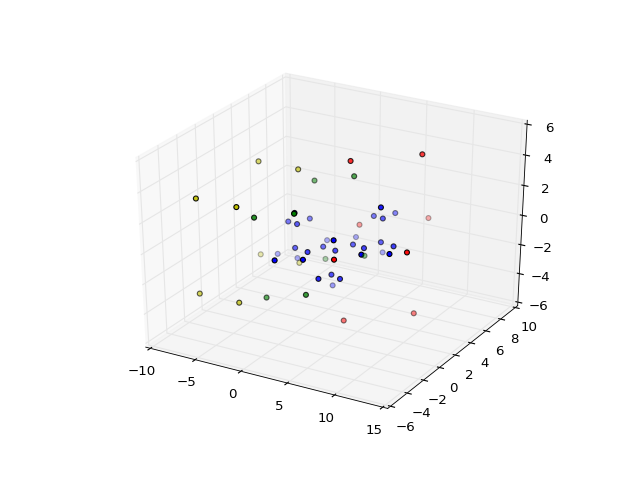

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(l[:,0], l[:,1], l[:,2])#, c='r')
ax.scatter(m[:,0], m[:,1], m[:,2])
ax.scatter(n[:,0], n[:,1], n[:,2])
ax.scatter(o[:,0], o[:,1], o[:,2])
ax.scatter(p[:,0], p[:,1], p[:,2])#, c = 'r')

#ax.scatter(nodes[-1][0].obb[0][:,0],  nodes[-1][0].obb[0][:,1], nodes[-1][0].obb[0][:,2], c ='r')#
#ax.scatter(lala.obb[0][:,0], lala.obb[0][:,1], lala.obb[0][:,2], c ='g')
#ax.scatter(nodes[-2][0].obb[0][:,0],  nodes[-2][0].obb[0][:,1], nodes[-2][0].obb[0][:,2], c ='g')
#ax.scatter(nodes[-2][1].obb[0][:,0],  nodes[-2][1].obb[0][:,1], nodes[-2][1].obb[0][:,2], c ='y')
#ax.scatter(nodes[-3][2].obb[0][:,0],  nodes[-3][2].obb[0][:,1], nodes[-3][2].obb[0][:,2], c ='r')

ax.scatter(nodes[-3][0].obb[0][:,0],  nodes[-3][0].obb[0][:,1], nodes[-3][0].obb[0][:,2], c ='g')
ax.scatter(nodes[-3][1].obb[0][:,0],  nodes[-3][1].obb[0][:,1], nodes[-3][1].obb[0][:,2], c ='y')
ax.scatter(nodes[-3][2].obb[0][:,0],  nodes[-3][2].obb[0][:,1], nodes[-3][2].obb[0][:,2], c ='r')